In [1]:
import os 
import sys
import glob
from tqdm import tqdm

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

import MDAnalysis as mda
from MDAnalysis.analysis import distances
from MDAnalysis.analysis.rms import RMSD

In [3]:
ref_pdb = '../../inputs/1KBH.pdb'
pdb_files = sorted(glob.glob('../../inputs/input_0*/prot.pdb'))
traj_files = sorted(glob.glob('../../md_runs/input_00*/prod_md/mdcrd'))

In [4]:
rmsd_profs = [] 
actr_sel = 'protein and name CA and resnum 1-47' 
ncbd_sel = 'protein and name CA and resnum 48-106' 
ref_traj = mda.Universe(ref_pdb)
dist_profs = []
for traj_file, pdb_file in zip(traj_files, pdb_files): 
    mda_traj = mda.Universe(pdb_file, traj_file, format='NC') 
#     print("Loaded strcture and run distance map ")
    ncbd_traj = mda_traj.select_atoms(ncbd_sel)
    actr_traj = mda_traj.select_atoms(actr_sel)
    dist = []
    for ts in tqdm(mda_traj.trajectory): 
        dist_map = distances.distance_array(ncbd_traj.positions, actr_traj.positions, box=ncbd_traj.dimensions)
        dist.append([ts.time, np.min(dist_map)])
    dist_profs += [dist]
    
dist_profs = np.array(dist_profs)

100%|██████████| 40000/40000 [00:34<00:00, 1159.50it/s]


In [5]:
dist_profs.shape

(8, 40000, 2)

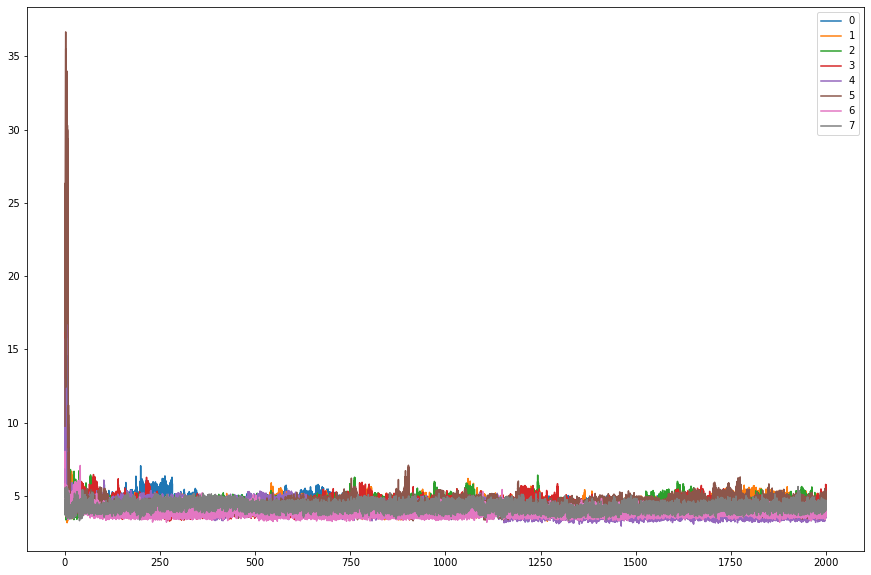

In [11]:
fig, ax = plt.subplots(figsize=(15,10)) 
n_traj = 0 

for j, dist in enumerate(dist_profs): 
    ax.plot(dist[:,0]/1000, dist[:,1], label=j) 
plt.legend()
plt.savefig('dist.pdf')

In [7]:
np.save('dist.npy', dist_profs) 

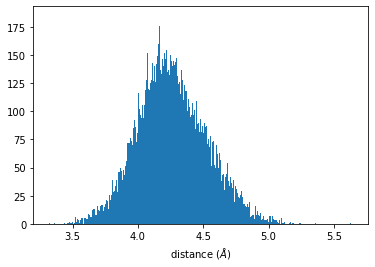

In [10]:
_ = plt.hist(dist[:,1], bins=1000)
# plt.xlim([3,8])
plt.xlabel(r'distance ($\AA$)')
plt.savefig('dist_hist.pdf')

In [6]:
%run ~/.matplotlib.py

In [7]:
frame_mini_RMSD = np.argmin(np.vstack(rmsd_profs)[:,2])

print np.min(np.vstack(rmsd_profs)[:,2])

traj_dict = {}
for traj_file in tqdm(sorted(traj_files[:])): 
    mda_traj = mda.Universe(pdb_file, traj_file) 
    traj_dict[traj_file] = len(mda_traj.trajectory)

from utils import find_frame, write_pdb_frame 
frame_mini_RMSD = np.argmin(np.vstack(rmsd_profs)[:,2])
traj_frame = find_frame(traj_dict, frame_mini_RMSD) 
print traj_frame

write_pdb_frame(traj_frame[0], pdb_file, traj_frame[1], 'low_RMSD.pdb')

 43%|████▎     | 27/63 [00:00<00:00, 131.58it/s]

0.4989168774386229


100%|██████████| 63/63 [00:00<00:00, 128.87it/s]


('../2F4K-0-protein/2F4K-0-protein-054.dcd', 734)


'low_RMSD.pdb'

/Users/hm/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


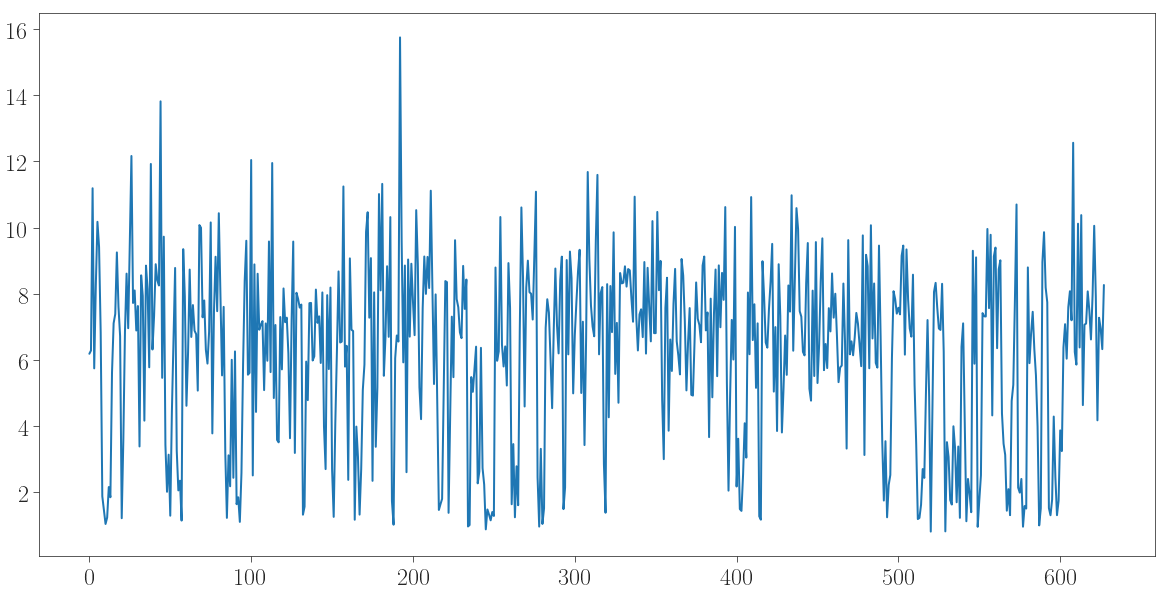

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(np.vstack(rmsd_profs)[::1000,2])

In [9]:
hist, bin_edges = np.histogram(rmsd_inst.rmsd[:,2], bins=50)

In [10]:
bin_labels = np.digitize(rmsd_inst.rmsd[:,2], bin_edges)

```python 
import MDAnalysis
from MDAnalysis.tests.datafiles import PDB, XTC

u = MDAnalysis.Universe(PDB, XTC)
protein = u.select_atoms("protein")
with MDAnalysis.Writer("protein.xtc", protein.n_atoms) as W:
    for ts in u.trajectory:
        W.write(protein)
```

In [11]:
np.unique(bin_labels, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51]),
 array([ 24,  57,  50,  40,  63,  85, 162, 215, 260, 308, 421, 444, 495,
        573, 550, 563, 535, 460, 409, 360, 374, 270, 241, 228, 143, 115,
         82,  62,  58,  36,  31,  25,  31,  26,  15,  11,  17,  19,  10,
          6,   6,  11,   7,   1,   3,   1,   1,   1,   1,   1]))

In [12]:
hist

array([ 24,  57,  50,  40,  63,  85, 162, 215, 260, 308, 421, 444, 495,
       573, 550, 563, 535, 460, 409, 360, 374, 270, 241, 228, 143, 115,
        82,  62,  58,  36,  31,  25,  31,  26,  15,  11,  17,  19,  10,
         6,   6,  11,   7,   1,   3,   1,   1,   1,   1,   1])

In [13]:
with mda.Writer('VHP.pdb', mda_traj.atoms.n_atoms) as W: 
    for label in range(10, 50): 
        frame_indices = np.array(np.where(bin_labels == label+1)).flatten()
        # Number of frame to output 
        n_frame = np.round(hist[label]/float(sum(hist[10:])) * 100)
        for i in range(int(n_frame)): 
            label = np.random.choice(frame_indices) 
            mda_traj.trajectory[label] 
            W.write(mda_traj.atoms)
        

/Users/hm/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/base.py:837: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


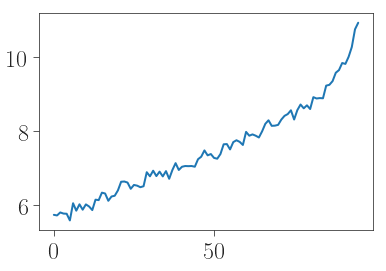

In [14]:
traj_file = 'VHP.pdb'
mda_traj = mda.Universe(pdb_file, traj_file) 
rmsd_inst = RMSD(mda_traj, ref_traj, select='protein and name CA') 
rmsd_inst.run()  

fig, ax = plt.subplots() 
ax.plot(rmsd_inst.rmsd[:,1], rmsd_inst.rmsd[:,2]) 

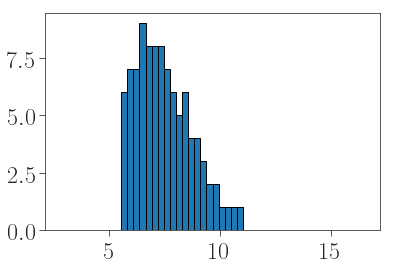

In [15]:
_ = plt.hist(rmsd_inst.rmsd[:,2], bins=bin_edges)

In [16]:
traj_dirs = sorted(glob.glob('../MD_exps/fs-pep/omm_runs_*'))

In [17]:
for traj_dir in traj_dirs[360:480]: 
    print os.listdir(traj_dir)

In [18]:
sum(np.round(hist[10:]/float(sum(hist[10:])) * 100))

96.0

In [19]:
from sklearn.decomposition import PCA
cm_pca = PCA(n_components=2).fit_transform(contact_matrices)

NameError: name 'contact_matrices' is not defined

In [ ]:
color = np.vstack(rmsd_profs)[:,2]
plt.scatter(cm_pca[:,0], cm_pca[:,1], c=color, cmap='jet', s=.5, alpha=.3)

In [ ]:
mda_traj = mda.Universe(pdb_file, traj_files) 

In [ ]:
len(mda_traj.trajectory)

In [ ]:
np.argmin(np.array(rmsd_inst.rmsd[:,2]))

In [ ]:
mda_traj.trajectory[0]

In [ ]:
mda_traj.atoms.write('vhp1ww.pdb')

In [ ]:
import simtk.openmm.app as app
import simtk.openmm as omm
import simtk.unit as u

import parmed as pmd

In [ ]:
top_file = '../MD_exps/VHP_exp/pdb/vhp1ww.top' 
pdb_file = '../MD_exps/VHP_exp/pdb/vhp1ww.pdb'

In [ ]:
pdb = pmd.load_file(top_file, xyz = pdb_file)

In [ ]:
app.PDBFile.writeFile(pdb.topology, mda_traj.atoms.positions - mda_traj.atoms.center_of_mass(), open('vhp1ww.pdb', 'w'))